In [1]:
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
ENCODING_DICT = {
            'a': 0,
            'f': 1,
            'e': 2,
            'c': 3,
            'b': 4,
            'h': 5,
            'v': 6,
            'z': 7,
            '2': 8,
            'x': 9,
            'g': 10,
            'm': 11,
            'r': 12,
            'u': 13,
            'p': 14,
            's': 15,
            'd': 16,
            'n': 17,
            '6': 18,
            'k': 19,
            't': 20
            }

DECODING_DICT = {
            0: 'a',
            1: 'f',
            2: 'e',
            3: 'c',
            4: 'b',
            5: 'h',
            6: 'v',
            7: 'z',
            8: '2',
            9: 'x',
            10: 'g',
            11: 'm',
            12: 'r',
            13: 'u',
            14: 'p',
            15: 's',
            16: 'd',
            17: 'n',
            18: '6',
            19: 'k',
            20: 't'
            }

In [3]:
def imagepath_to_captcha(imagepath):
    return imagepath.split("_")[1].split(".")[0]

def to_onehot(captcha):
    label = np.zeros((len(captcha), len(ENCODING_DICT)))
    for index, char in enumerate(captcha):
        label[index, ENCODING_DICT[char]] = 1
    return tf.convert_to_tensor(label, tf.float32)
    # return tf.reshape(tf.convert_to_tensor(label, tf.float32), [-1])

def captcha_from_onehot(tensor):
    label = []
    for index in tf.argmax(tensor, 1).numpy():
        label.append(DECODING_DICT[index])
    return "".join(label)

def load_dataset(filepath):
    filenames = os.listdir(filepath)
    x, y = [], []
    for file in filenames:
        imagepath = filepath + "/" + file
        image = tf.io.read_file(imagepath)
        image = tf.image.decode_image(image)
        pixels = tf.image.convert_image_dtype(image, tf.float32)
        # To show images: 
        # plt.imshow(tf.reshape(pixels, image.shape))
        # plt.title('Image as Pixels')
        # plt.show()
        x.append(pixels)
        captcha = imagepath_to_captcha(file).lower()
        y.append(to_onehot(captcha))
    return (tf.convert_to_tensor(x, tf.float32), tf.convert_to_tensor(y, tf.float32))


# Read input data

In [4]:
train_x, train_y = load_dataset("dataset/train")
test_x, test_y = load_dataset("dataset/test")

print("Training input shape:", train_x.shape)
print("Training output shape:", train_y.shape)
print("Testing input shape:", test_x.shape)
print("Testing output shape:", test_y.shape)

Training input shape: (8501, 50, 250, 3)
Training output shape: (8501, 6, 21)
Testing input shape: (1500, 50, 250, 3)
Testing output shape: (1500, 6, 21)


In [73]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(64, (2, 2), 
                              (2, 2),
                            #   kernel_regularizer=keras.regularizers.L2(1e-4), 
                              activation='relu', input_shape=(50, 250, 3)))
model.add(keras.layers.AveragePooling2D(2, 2))
# model.add(keras.layers.MaxPooling2D(2, 2))
# model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.Conv2D(64, (2, 2), activation='sigmoid'))
# model.add(keras.layers.MaxPooling2D(2, 2))
model.add(keras.layers.Conv2D(64, (2, 2), (2, 2),
                              # kernel_regularizer=keras.regularizers.L2(1e-4), 
                              activation='relu'))
model.add(keras.layers.MaxPooling2D(2, 2))

model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(8064, activation='relu'))
# model.add(keras.layers.Dense(1440, activation='relu'))
# model.add(keras.layers.Dense(504, activation=keras.layers.LeakyReLU(alpha=0.1)))
# model.add(keras.layers.Dense(504, activation='relu'))
# model.add(keras.layers.Dense(units=252,
#             kernel_regularizer=keras.regularizers.L2(5 * 1e-4),
#             activation='relu'))
model.add(keras.layers.Dense(126, activation='relu'))
model.add(keras.layers.Dense(126, activation='softmax'))
model.add(keras.layers.Reshape((6, 21)))


model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 25, 125, 64)       832       
                                                                 
 average_pooling2d_6 (Avera  (None, 12, 62, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_31 (Conv2D)          (None, 6, 31, 64)         16448     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 3, 15, 64)         0         
 ng2D)                                                           
                                                                 
 flatten_15 (Flatten)        (None, 2880)              0         
                                                                 
 dense_51 (Dense)            (None, 126)             

In [6]:
# ResNet50, how to make this work?
# Define input shape
# input_shape = (50, 250, 3)

# # Custom input layer
# input_tensor = keras.layers.Input(shape=input_shape)

# # Preprocess the input (optional)
# x = keras.applications.resnet50.preprocess_input(input_tensor)


# model = keras.applications.resnet50.ResNet50(
#     include_top = True,
#     weights = 'imagenet',
# input_tensor = x)

# model.summary()

In [74]:


model.compile(
    optimizer = "adam",
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

# graphwiz doesn't install on gLinux ffs.
# tf.keras.utils.plot_model(model, show_shapes=True)


In [75]:
callbacks = [keras.callbacks.EarlyStopping(monitor = 'loss', 
                                           patience = 2, 
                                           restore_best_weights = True)]

history = model.fit(train_x, train_y,
                    epochs = 100,
                    callbacks = callbacks)

print(history.history)

Epoch 1/100
266/266 [==============================] - 14s 51ms/step - loss: 3.0318 - accuracy: 0.0590
Epoch 2/100
266/266 [==============================] - 14s 54ms/step - loss: 2.5360 - accuracy: 0.2112
Epoch 3/100
266/266 [==============================] - 14s 52ms/step - loss: 1.9562 - accuracy: 0.3740
Epoch 4/100
266/266 [==============================] - 14s 51ms/step - loss: 1.6106 - accuracy: 0.4822
Epoch 5/100
266/266 [==============================] - 14s 52ms/step - loss: 1.3650 - accuracy: 0.5591
Epoch 6/100
266/266 [==============================] - 14s 52ms/step - loss: 1.1624 - accuracy: 0.6249
Epoch 7/100
266/266 [==============================] - 14s 52ms/step - loss: 1.0021 - accuracy: 0.6736
Epoch 8/100
266/266 [==============================] - 14s 53ms/step - loss: 0.8645 - accuracy: 0.7180
Epoch 9/100
266/266 [==============================] - 14s 53ms/step - loss: 0.7579 - accuracy: 0.7518
Epoch 10/100
266/266 [==============================] - 18s 69ms/step - l

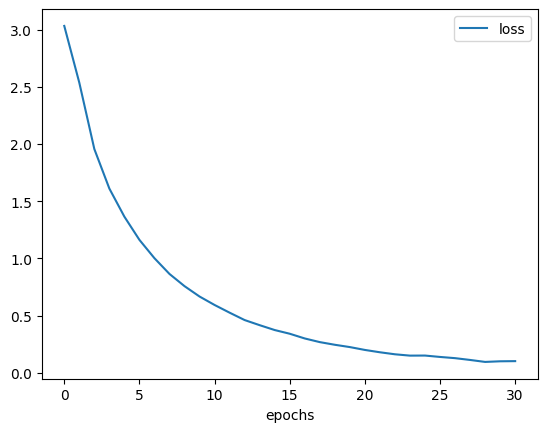

In [78]:
plt.plot(history.history['loss'], label = 'loss')
# plt.plot(1 - np.array(history.history['accuracy']), label = 'accuracy')
plt.legend()
plt.xlabel('epochs')
plt.show()

In [79]:
model.evaluate(test_x, test_y)

47/47 [==============================] - 1s 20ms/step - loss: 2.1562 - accuracy: 0.6820


[2.1562283039093018, 0.6819999814033508]